<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/4_Second_order_methods/4_3_Second.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 4: Second order methods

# The Second-Order Optimality Condition

In this Section we begin by discussing how to formally describe the convexity or concavity of a quadratic function - with the second order Taylor series specifically in mind.  This will help us better understand and quantify the behavior of Newton's method - our main second order algorithm - introduced in the following Section.  We then discuss the final calculus-based descriptor of a function's minima and stationary points more broadly speaking: the *second order condition for optimality*.  Unlike the zero or first order conditions, the second order condition does not directly help us with our main pursuit of finding (approximate) global minima of a function.  In fact, as we will see later, second order algorithms are actually explicitly built to satisfy the *first* not the *second* order optimality condition.  So while the second order condition provides further characterization of a function's stationary points, it is of largely mathematical interest.

In [1]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone library subdirectory
    if not Path('chapter_4_library').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/4_Second_order_methods/chapter_4_library
    else:
        print('chapter_4_library already cloned!')

    # clone videos
    if not Path('chapter_4_videos').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/4_Second_order_methods/chapter_4_videos
    else:
        print('chapter_4_videos already cloned!')

# append path for local library, data, and image import
import sys
sys.path.append('./chapter_4_library')
sys.path.append('./chapter_4_videos') 

# import section helper
import section_4_3_helpers

# video paths
video_path_1 = 'chapter_4_videos/animation_3.mp4'
video_path_2 = 'chapter_4_videos/animation_4.mp4'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
from base64 import b64encode

def show_video(video_path, width = 1000):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={width} controls><source src="{video_url}"></video>""")

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=9dd385f1d3f53214567760a9a205db8bcc5eaffef0cb086e154d30288882c462
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt
Cloning into 'chapter_4_library'...
done.
Cloning into 'chapter_4_videos'...
done.


## Curvature and single-input functions

Below we animate the second order Taylor series approximation to 

\begin{equation}
g(w) = \text{sin}(3w) + 0.1w^2
\end{equation}

(this function is drawn in black), the point about which the approximation is defined drawn in green, and the second order Taylor series itself is shown in torquoise. 

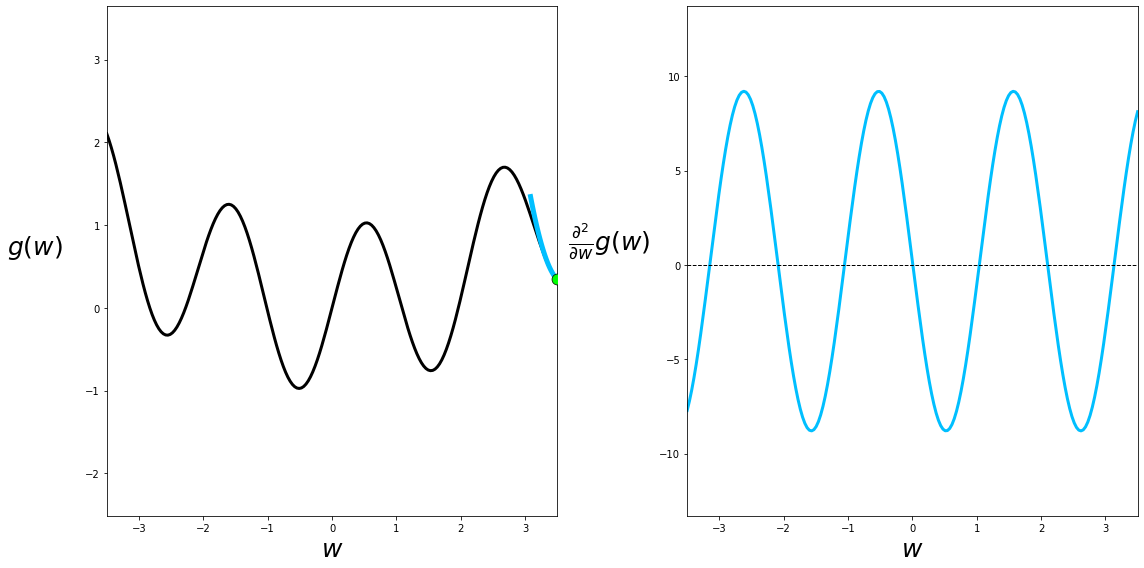

In [2]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.sin(3*w) + 0.1*w**2

# create an instance of the visualizer with this function 
taylor_viz = section_4_3_helpers.visualizer(g = g)

# run the visualizer for our chosen input function
taylor_viz.draw_it(savepath=video_path_1,num_frames = 200,max_val = 3.5,fps=20)

In [4]:
show_video(video_path_1, width=800)

One thing that can be seen in this simple example is that the second order approximation appears to match the local convexity/concavity of the underlying function near the point on which it is defined.  In other words, if at this point the function appears to be convex (facing upwards) locally, the second order approximation is too *convex* and upward facing.  If, on the other hand, the point is on a part of the function where it is facing downward or *concave*, the second order approximation is also concave and facing downward.  And the opposite holds as well - if the second order approximation is convex/concave, so too is the underlying function.

This is not a random coincidence.  Because the second order Taylor Series is a quadratic built to match a function locally this fact always holds - regardless of the type of function and whether it takes in a single input or multiple inputs.  Now, because quadratic functions are relatively simple objects (we in fact dedicated an entire Section to detailing their characteristics) we can easily tell when a quadratic is convex or concave. A general single input quadratic

\begin{equation}
g(w) = a + bw + cw^2 
\end{equation}

is convex if $a \geq 0$, and concave if $c \leq 0$ (technically if $c=0$ the function - being a line - is both convex and concave).  Given that the second order Taylor Series $h(w)$ of a single input function $g(w)$ at a point $w_0$ is given as 

\begin{equation}
h(w) = g(w^0) + \left(\frac{\mathrm{d}}{\mathrm{d}w}g(w^0)\right)(w - w^0) +  \frac{1}{2}\left(\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w^0)\right)(w - w^0)^2
\end{equation}

and since  $c = \frac{1}{2}\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w^0)$ is the coefficient of the squared term, it follows that the Taylor Series approximation is convex if $\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w^0) \geq 0$ and concave if $\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w^0) \leq 0$.

Since we have already established that a function $g(w)$ is convex/concave at a point $w_0$ if and only if its second order Taylor Series approximation is convex/concave there, this tells us that we can further say that $g(w)$ is convex at $w_0$ if and only if $\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w^0) \geq 0$ or $\leq 0$ respectively.

> A function $g(w)$ is convex at $w_0$ if and only if $\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w^0) \geq 0$.  Likewise it is concave if and only if $\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w^0) \leq 0$.

Looking back at the example above we can see this is precisely what is going on in the right panel - where the value of the second derivative is plotted simultaneously along with the second order Taylor Series drawn in the left panel.  

It follows then that if a function $g$ is convex at each of its input points, it is convex overall (like a general single-input quadratic function is when $c \geq 0$).

> A function $g$ is convex if it is convex at each of its input points, or equivalently if $\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w) \geq 0$ everywhere.  Likewise it is concave if $\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w) \leq 0$ everywhere.

We can see this in any single-input example like the one plotted below

$$
g(w) = \frac{1}{50}\left(w^4 + w^2 + 10w\right)
$$

where once again the function itself as well as the second order Taylor Series approximation is drawn in the left panel, while the value of the second derivative is plotted simultaneously in the right panel.

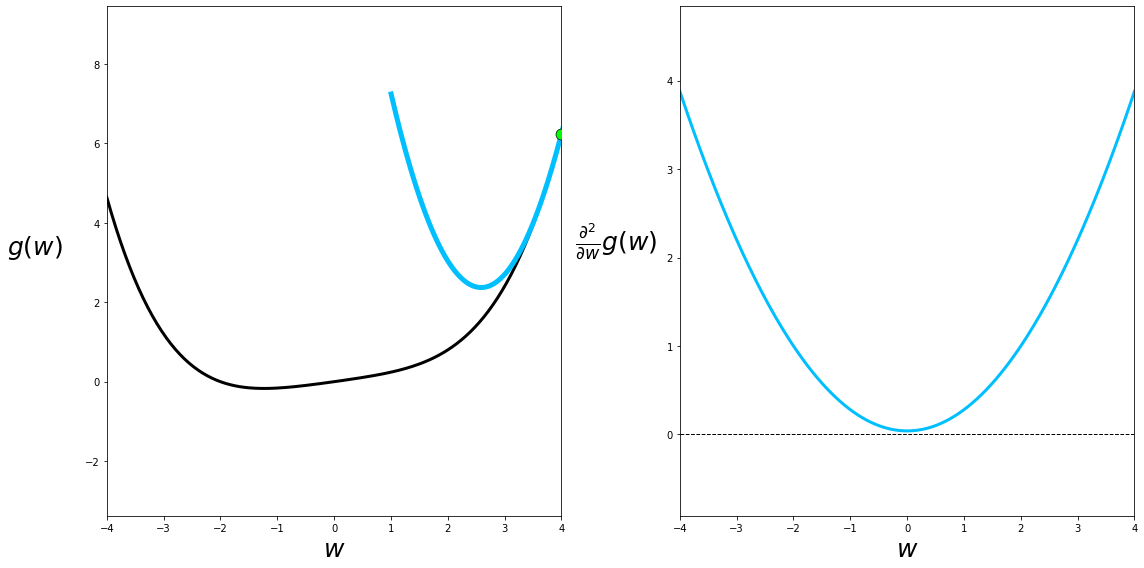

In [5]:
# what function should we play with?  Defined in the next line.
g = lambda w: 1/float(50)*(w**4 + w**2 + 10*w)

# create an instance of the visualizer with this function 
taylor_viz = section_4_3_helpers.visualizer(g = g)

# run the visualizer for our chosen input function
taylor_viz.draw_it(savepath=video_path_2,num_frames = 200,max_val = 4,fps=20)

In [8]:
show_video(video_path_2, width=800)

#### <span style="color:#a50e3e;">Example 1 </span> Hand calculations examples

Here are a few additional examples with second derivatives calculated algebraically.

- $g\left(w\right)=w^{3}$ has second derivative $\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w)=6w$.  From the second derivative we see that $g$ is concave when $w\leq 0$ and convex when $w\geq 0$.


- $g\left(w\right)=e^{w}$ has second derivative $\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w) = e^{w}$
which is positive for any choice of $w$, and so $g$ is convex everywhere and therefore is a convex function.


- $g\left(w\right)=\mbox{sin}\left(w\right)$ has second derivative
$\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w)=-\mbox{sin}\left(w\right)$. This shows us that $g$ is convex when $\text{sin}(w) < 0$ and concave otherwise. 


- $g\left(w\right)=w^{2}$ has second derivative $\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w)=2$, which is always positive and so $g$ is convex everywhere, or in other words, is a convex function.

## Curvature and multi-input functions

The analogous rule for judging the convexity/concavity of a multi-input function via the convexity/concavity of its second order Taylor Series holds as well.  However as detailed in the Section on quadratic functions, the convexity/concavity of a general multi-input quadratic function

\begin{equation}
g(\mathbf{w}) =  a + \mathbf{b}^T \mathbf{w}^{\,} + \mathbf{w}^T \mathbf{C}^{\,} \mathbf{w}^{\,} 
\end{equation}

is determined not by the value of the $N\times N$ symmetric matrix $\mathbf{C}$ but by its *eigenvalues*.  In particular the quadratic is convex along its $n^{th}$ input if and only if its $n^{th}$ eigenvalue $d_n \geq 0$, and conversely concave if $d_n \leq 0$.  Following, the quadratic is convex/concave in every input dimension if $d_n \geq 0$ or $d_n \leq 0$ respectively.  This reduces to the same condition on the single-input quadratic when $N=1$ (as detailed in the previous Section).

Given this condition on the convexity/concavity of a multi-input quadratic, in complete analogy to the case of a single-input function when it comes to the second order Taylor Series approximation of a multi-input function $g(\mathbf{w})$ at a point $\mathbf{w}^0$

$$
h(\mathbf{w}) = g(\mathbf{w}^0) + \nabla g(\mathbf{w}^0)^T(\mathbf{w} - \mathbf{w}^0) + \frac{1}{2}(\mathbf{w} - \mathbf{w}^0)^T \nabla^2 g\left(\mathbf{w}^0\right) (\mathbf{w} - \mathbf{w}^0)
$$

it is the eigenvalues of the Hessian matrix $\mathbf{C} = \nabla^2 g\left(\mathbf{w}^0\right)$ that determine the convexity of the approximation, and hence of the underlying function at $\mathbf{w}^0$.  More specifically $g$ is convex at $\mathbf{w}^0$ if and only if the approximation is convex in every one of its input dimensions, or in other words if $ \nabla^2 g\left(\mathbf{w}^0\right)$ has all nonnegative eigenvalues (such a matrix is called *positive semi-definite*).  Likewise $g(\mathbf{w}^0)$ is concave if $ \nabla^2 g\left(\mathbf{w}^0\right)$ has all non-positive eigenvalues.

> $g$ is convex at $\mathbf{w}^0$ if and only if the second order Taylor Series approximation is convex in every one of its input dimension, or in other words if $ \nabla^2 g\left(\mathbf{w}^0\right)$ has all nonnegative eigenvalues.  Likewise $g(\mathbf{w}^0)$ is concave if $ \nabla^2 g\left(\mathbf{w}^0\right)$ has all non-positive eigenvalues.

Furthermore a function $g$ is a *convex function* if it is convex everywhere, or if $ \nabla^2 g\left(\mathbf{w}\right)$ has all nonnegative eigenvalues at every input $\mathbf{w}$.  Conversely it is a concave function if $ \nabla^2 g\left(\mathbf{w}\right)$ has all non-positive eigenvalues everywhere.

> $g$ is a *convex function* if it is convex everywhere, or if $ \nabla^2 g\left(\mathbf{w}\right)$ has all nonnegative eigenvalues at every input $\mathbf{w}$.  Conversely it is a concave function if $ \nabla^2 g\left(\mathbf{w}\right)$ has all non-positive eigenvalues everywhere.

## The second order condition

Studying a few simple examples it is easy to come to some far-reaching conclusions about how the second derivative helps unveil the identity of stationary points.  In the next Python cell we plot the three single-input functions along with their first and second order derivatives.  We mark in green the evaluation of all stationary points by the function in green (where we also show the tangent line in green), as well as the evaluations by the first and second derivatives marking each evaluation in green.  In the first and second derivative panels we draw the horizontal zero axis as a dashed black line.

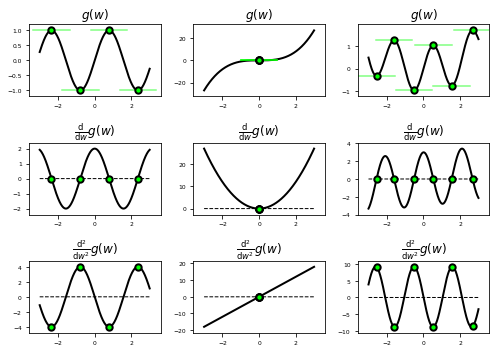

In [9]:
# plot a single input quadratic in both two and three dimensions
func1 = lambda w: np.sin(2*w)
func2 = lambda w: w**3
func3 = lambda w: np.sin(3*w) + 0.1*w**2

# use custom plotter to show both functions
section_4_3_helpers.show_stationary_v2(func1 = func1,func2 = func2,func3 = func3)

Studying these simple examples we can see consistent behavior of certain stationary points.  In particular we can see consistency in how the value of a function's second derivative at a stationary point $w^0$ helps us identify whether it is a local minima, local maxima, or saddle point.  In the examples above we see that a stationary point $w^0$ is 

- a local or global minimum if $\frac{\partial^2}{\partial w^2}g(w) > 0$ (since it occurs at *convex* portions of a function)


- a local or global maximum if  $\frac{\partial^2}{\partial w^2}g(w) < 0$ (since it occurs at *concave* portions of a function)


- a saddle point if  $\frac{\partial^2}{\partial w^2}g(w) = 0$ and $\frac{\partial^2}{\partial w^2}g(w)$ changes sign at $w$ (since it occurs at an *inflection point* of a function, i.e., where a function goes from concave to convex or vice-versa)

These second order characteristics hold more generally as well for any single input function, and taken together  are indeed the *second order condition for optimality* for single input functions.

With multi-input functions the analogous second order condition holds. As with all things having to do with convexity/concavity and the second order derivative matrix (a.k.a. the Hessian) the rule translates to the *eigenvalues of the Hessian*.  More specifically a stationary point $\mathbf{w}^0$ of a multi-input function $g(\mathbf{w}^0)$ is

- a local minimum if all eigenvalues of $\nabla^2 g(\mathbf{w}^0)$ are positive (since it occurs at *convex* portions of a function)


- a local maximum if all eigenvalues of $\nabla^2 g(\mathbf{w}^0)$ are negative (since it occurs at *concave* portions of a function)


- a saddle point if the eigenvalues of $\nabla^2 g(\mathbf{w}^0)$ are of mixed values (i.e., some are negative, some are positive) (since it occurs at an *inflection point* of a function)

These rules reduce to those just stated for single-input functions when $N=1$ since then the Hessian matrix collapses into a single second order derivative. 

> **Second order condition for optimality**: the second derivative(s) of a function can determine whether a stationary point is a local minimum, local maximum, or saddle point.  Generally speaking a stationary point $\mathbf{w}^0$ is a local minimum, local maximum, or saddle point if the eigenvalues of $\nabla^2 g(\mathbf{w}^0)$ are all positive, negative, or mixed, respectively.

## The low practical utility of the second order condition 

As we have seen in the previous [Section 3.2](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_2_First.html) the first order condition defines all stationary points (minima, maxima, and saddle points) via a single condition - the first order system of equations.  In theory if we could compute all solutions to such a system for a given function we could - in order to determine the global minima - simply evaluate all of the solutions and find the smallest evaluators (declaring them the global minima).  Then using the second order optimality condition we could - at least theoretically speaking - identify the nature of a stationary point.  In other words, the second order condition is a filter that can determine the identity of a given stationary point.

Unlike the zero and first order conditions, the second order condition (while mathematically interesting) is not all together useful in practice (at least in machine learning applications).   The second order condition is a *filter* that helps identify the nature of stationary points, but our main struggle in optimization is to actually find stationary points to begin with (or - more accurately - points nearby stationary points).  Furthermore, in machine learning we almost always find (points nearby) minima since we either deal with convex functions (as we often do in with applications linear machine learning) whose stationay points are minima, or design algorithms that do not tend to halt at saddle points so that once again the points we find via optimization are (nearby) minima.